In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models

In [2]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

True


In [3]:
EPOCHS = 100
BATCH_SIZE = 64

test_acc_history = []
train_acc_history = []
test_loss_history = []
train_loss_history = []

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data',train=True,download=True,transform=transforms.Compose([
                          transforms.RandomCrop(32, padding=4),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])), batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./data',train=False,transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) ])), batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data


In [5]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes=16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.layer1 = self._make_layer(16,2, stride=1)
        self.layer2 = self._make_layer(32,2, stride=2)
        self.layer3 = self._make_layer(64,2, stride=2)

        self.linear = nn.Linear(64, num_classes)
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers=[]
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

In [7]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.1)

In [8]:
def train(model, train_loader, optimizer, epoch):
    train_loss, train_accuracy, running_train_loss, running_train_correct = 0,0,0,0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        running_loss = 0
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        _, pred = torch.max(output.data, 1)
        running_train_correct += (pred == target).sum().item()
        running_train_loss += loss.item()
    train_loss = running_train_loss/len(train_loader)
    train_accuracy = (running_train_correct / len(train_loader.dataset) * 100)

    return train_loss, train_accuracy

In [9]:
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100*correct / len(test_loader.dataset)

    return test_loss, test_accuracy

In [10]:
from tqdm import tqdm
for epoch in tqdm(range(1, EPOCHS+1)):
    scheduler.step()
    train_loss, train_accuracy = train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print('[{}] Train Loss: {:.4f}, Train_Accuracy: {:.2f}%'.format(
            epoch, train_loss, train_accuracy
        ))
    print('[{}] Test Loss: {:.4f}, Test_Accuracy: {:.2f}%'.format(
        epoch, test_loss, test_accuracy
    ))
    test_acc_history.append(test_accuracy)
    train_acc_history.append(train_accuracy)
    test_loss_history.append(test_loss)
    train_loss_history.append(train_loss)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  1%|          | 1/100 [00:36<59:54, 36.31s/it]

[1] Train Loss: 4.0011, Train_Accuracy: 7.77%
[1] Test Loss: 3.7289, Test_Accuracy: 11.66%


  2%|▏         | 2/100 [01:06<53:20, 32.66s/it]

[2] Train Loss: 3.4613, Train_Accuracy: 16.25%
[2] Test Loss: 3.5387, Test_Accuracy: 16.79%


  3%|▎         | 3/100 [01:36<51:09, 31.65s/it]

[3] Train Loss: 3.1141, Train_Accuracy: 22.47%
[3] Test Loss: 3.2288, Test_Accuracy: 20.53%


  4%|▍         | 4/100 [02:06<49:38, 31.02s/it]

[4] Train Loss: 2.8533, Train_Accuracy: 27.37%
[4] Test Loss: 3.3183, Test_Accuracy: 23.72%


  5%|▌         | 5/100 [02:37<48:36, 30.70s/it]

[5] Train Loss: 2.3421, Train_Accuracy: 38.59%
[5] Test Loss: 2.2261, Test_Accuracy: 40.73%


  6%|▌         | 6/100 [03:07<47:49, 30.52s/it]

[6] Train Loss: 2.1990, Train_Accuracy: 41.61%
[6] Test Loss: 2.1400, Test_Accuracy: 43.10%


  7%|▋         | 7/100 [03:37<47:05, 30.38s/it]

[7] Train Loss: 2.1213, Train_Accuracy: 43.09%
[7] Test Loss: 2.1110, Test_Accuracy: 43.46%


  8%|▊         | 8/100 [04:07<46:29, 30.32s/it]

[8] Train Loss: 2.0594, Train_Accuracy: 44.31%
[8] Test Loss: 2.0658, Test_Accuracy: 44.57%


  9%|▉         | 9/100 [04:39<46:36, 30.73s/it]

[9] Train Loss: 2.0109, Train_Accuracy: 45.23%
[9] Test Loss: 2.0446, Test_Accuracy: 44.99%


 10%|█         | 10/100 [05:09<45:48, 30.54s/it]

[10] Train Loss: 1.8808, Train_Accuracy: 48.89%
[10] Test Loss: 1.9133, Test_Accuracy: 48.18%


 11%|█         | 11/100 [05:39<44:58, 30.32s/it]

[11] Train Loss: 1.8552, Train_Accuracy: 49.28%
[11] Test Loss: 1.8888, Test_Accuracy: 48.64%


 12%|█▏        | 12/100 [06:08<44:15, 30.18s/it]

[12] Train Loss: 1.8416, Train_Accuracy: 49.85%
[12] Test Loss: 1.8763, Test_Accuracy: 48.93%


 13%|█▎        | 13/100 [06:38<43:40, 30.12s/it]

[13] Train Loss: 1.8291, Train_Accuracy: 49.99%
[13] Test Loss: 1.8707, Test_Accuracy: 48.80%


 14%|█▍        | 14/100 [07:08<42:48, 29.87s/it]

[14] Train Loss: 1.8143, Train_Accuracy: 50.20%
[14] Test Loss: 1.8645, Test_Accuracy: 49.29%


 15%|█▌        | 15/100 [07:38<42:18, 29.86s/it]

[15] Train Loss: 1.8011, Train_Accuracy: 50.60%
[15] Test Loss: 1.8510, Test_Accuracy: 49.56%


 16%|█▌        | 16/100 [08:08<41:50, 29.89s/it]

[16] Train Loss: 1.7959, Train_Accuracy: 50.82%
[16] Test Loss: 1.8563, Test_Accuracy: 49.26%


 17%|█▋        | 17/100 [08:37<41:10, 29.76s/it]

[17] Train Loss: 1.7949, Train_Accuracy: 50.84%
[17] Test Loss: 1.8481, Test_Accuracy: 49.46%


 17%|█▋        | 17/100 [08:39<42:14, 30.54s/it]


KeyboardInterrupt: ignored

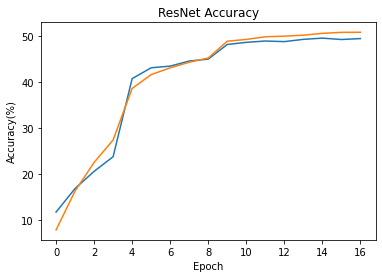

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

test_acc_ser = pd.Series(test_acc_history)
train_acc_ser = pd.Series(train_acc_history)
test_loss_ser = pd.Series(test_loss_history)
train_loss_ser = pd.Series(train_loss_history)

test_acc_ser.plot(label='Test')
train_acc_ser.plot(label='Train')
plt.title('ResNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.savefig('./ResNet_accuracy.png', dpi=500)
plt.show()

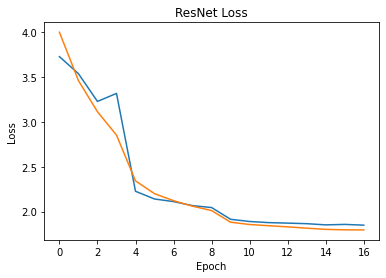

In [12]:
test_loss_ser.plot(label='Test')
train_loss_ser.plot(label='Train')
plt.title('ResNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('./ResNet_loss.png', dpi=500)
plt.show()

In [13]:
torch.save(model.state_dict(), './ResNet.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('conv1.weight', tensor([[[[-0.1961,  0.1853, -0.0264],
          [-0.0389,  1.2774,  0.1942],
          [ 0.0986,  0.2556, -0.2520]],

         [[-0.2011, -0.1082, -0.2376],
          [-0.4138,  0.4276, -0.3126],
          [-0.2149, -0.5102, -0.6368]],

         [[-0.1894,  0.2624,  0.0745],
          [-0.2570,  1.1409,  0.4899],
          [-0.2048,  0.1057,  0.0360]]],


        [[[-0.0285, -0.4000, -0.2956],
          [-0.1236, -0.4142, -0.4334],
          [ 0.0229, -0.5028, -0.4482]],

         [[-0.0293, -0.0354, -0.0203],
          [ 0.0758,  0.1748,  0.1195],
          [-0.1078, -0.2956, -0.2713]],

         [[ 0.1026,  0.4887,  0.3359],
          [ 0.3841,  0.9696,  0.8319],
          [-0.1216,  0.1429,  0.1129]]],


        [[[ 0.0169, -0.0187, -0.0168],
          [-0.2750, -0.1946, -0.2110],
          [-0.2412, -0.2593, -0.1710]],

         [[ 0.2723,  0.2575,  0.2581],
          [ 0.0846,  0.2405,  0.1698],
          [ 0.0687,  0.